# Fitting and modeling

## Tutorial overview

This notebook shows how to
- Read a DL4 datasets file
- Define the `~gammapy.modeling.models.Models` to apply to the datasets from a list of` ~gammapy.modeling.models.SkyModel`.
- Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
- Inspect the residuals
- See how significant our source is

## Import all the necessary libraries for the tutorial

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from regions import CircleSkyRegion

from gammapy.datasets import MapDataset, Datasets
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    GaussianSpatialModel,
    PowerLawSpectralModel,
    FoVBackgroundModel,
    SkyModel,
    Models
)
from gammapy.modeling.selection import select_nested_models
from gammapy.stats.utils import ts_to_sigma

Read a DL4 datasets file

In [2]:
stacked = MapDataset.read(f'stacked_MapDataset.fits')

Recall: we can peek the `MapDataset`.

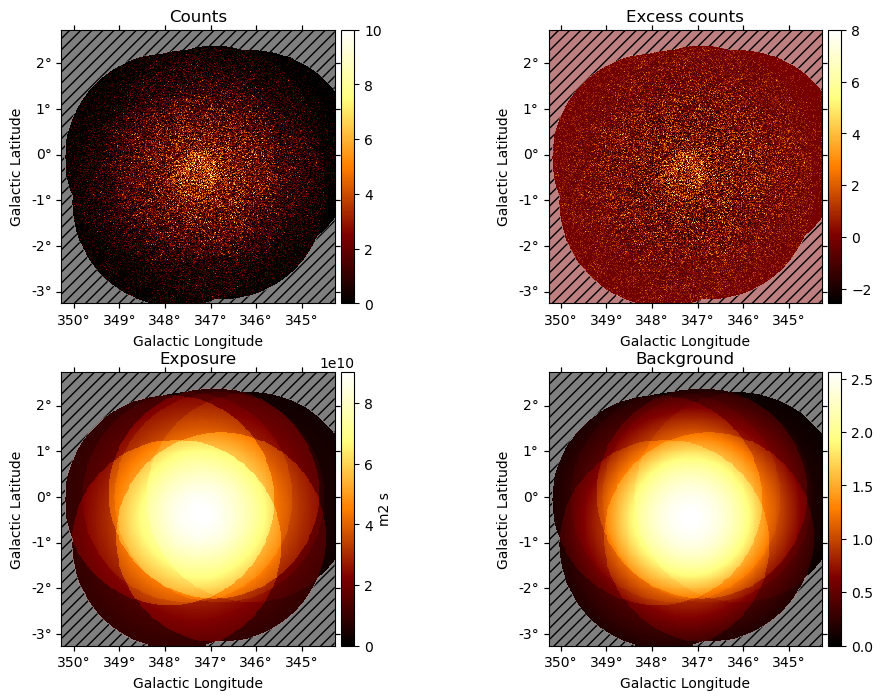

In [3]:
stacked.peek()

In [4]:
print(stacked)

MapDataset
----------

  Name                            : rxj-stacked 

  Total counts                    : 74124 
  Total background counts         : 71944.71
  Total excess counts             : 2179.29

  Predicted counts                : 71944.71
  Predicted background counts     : 71944.71
  Predicted excess counts         : nan

  Exposure min                    : 3.54e+05 m2 s
  Exposure max                    : 6.48e+09 m2 s

  Number of total bins            : 1350000 
  Number of fit bins              : 1058640 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




# 3D modeling -- Fit a model to the dataset


**Start with the position for the SNR. We saw how to do this in the previous tutorial.**

In [5]:
target_position = SkyCoord.from_name('RX J1713.7-3946').galactic

The 3D analysis consists of a simultaneous fit of the spectral and spatial parameters of one or multiple sources. Here, we focus only on a single source. To perform the fit, we firstly need to define a model: we can try with a Gaussian morphology and a powerlaw spectral shape:

In [6]:
spatial_model = GaussianSpatialModel(
    lon_0=target_position.l, lat_0=target_position.b, sigma=0.3*u.deg, frame='galactic',
)

# We limit the model position inside a 1 deg box centered on the reference position of RX J1713
spatial_model.lon_0.min = spatial_model.lon_0.value - 0.5
spatial_model.lon_0.max = spatial_model.lon_0.value + 0.5

**Now limit the `lat_0` values yourself, just as we did above.**

In [7]:
spatial_model.lat_0.min = spatial_model.lat_0.value - 0.5
spatial_model.lat_0.max = spatial_model.lat_0.value + 0.5

In [8]:
spectral_model = PowerLawSpectralModel(index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1*u.TeV)

**Create a `SkyModel` from this.**

In [9]:
sky_model = SkyModel(spectral_model=spectral_model, spatial_model=spatial_model, name='rxj')

Now, we define a global `~gammapy.modeling.model.FoVBackgroundModel` in order to finely adjust the level of residual CR backgroud. This should not be forgotten.

Note: we assume the background is well know and can be taken from the IRF bkg model

In [10]:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)

Now we assign these models to our reduced dataset:

In [11]:
stacked.models = Models([sky_model, bkg_model])

**Look at the stacked dataset again to see what it contains.**

In [12]:
print(stacked)

MapDataset
----------

  Name                            : rxj-stacked 

  Total counts                    : 74124 
  Total background counts         : 71944.71
  Total excess counts             : 2179.29

  Predicted counts                : 74483.46
  Predicted background counts     : 71944.71
  Predicted excess counts         : 2538.75

  Exposure min                    : 3.54e+05 m2 s
  Exposure max                    : 6.48e+09 m2 s

  Number of total bins            : 1350000 
  Number of fit bins              : 1058640 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 406565.43

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : rxj
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
      

## Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting the `stats` method of the dataset to the minimizer. By default, it uses `iminuit`.

Its constructor takes a list of dataset as argument.

In [13]:
fit = Fit()
result = fit.run([stacked])
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 170
	total stat : 406475.53

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [14]:
stacked.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str15,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
rxj,,index,1.9124e+00,,3.945e-02,nan,nan,False,False,,
rxj,,amplitude,2.3033e-11,TeV-1 s-1 cm-2,1.146e-12,nan,nan,False,True,,
rxj,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
rxj,,lon_0,3.4726e+02,deg,1.754e-02,3.468e+02,3.478e+02,False,False,,
rxj,,lat_0,-3.7585e-01,deg,1.698e-02,-7.569e-01,2.431e-01,False,False,,
rxj,,sigma,3.6342e-01,deg,1.302e-02,0.000e+00,nan,False,False,,
rxj,,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,,
rxj,,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,,
rxj-stacked-bkg,,norm,9.9048e-01,,4.107e-03,nan,nan,False,True,,


### Inspecting residuals

For any fit it is useful to inspect the residual images. We have a few options on the dataset object to handle this. First we can use `.plot_residuals_spatial()` to plot a residual image, summed over all energies:

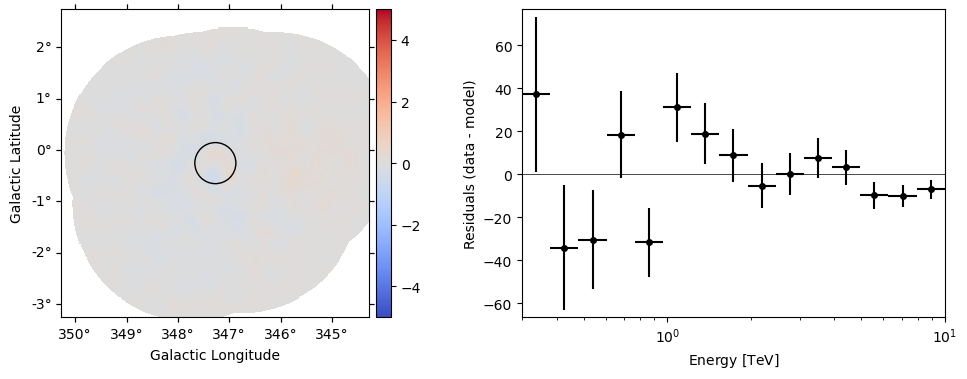

In [15]:
region = CircleSkyRegion(
    center=target_position, radius=0.4 * u.deg
)
stacked.plot_residuals(kwargs_spectral={"region":region});

## How significant is this source?

In [16]:
sky_model.spatial_model.lon_0.frozen = False
sky_model.spatial_model.lat_0.frozen = False
sky_model.spatial_model.sigma.frozen = False

sky_model.spectral_model.amplitude.frozen = False
sky_model.spectral_model.index.frozen = True

datasets = Datasets([stacked])
datasets.models =  Models([sky_model, bkg_model])

parameters = [sky_model.spectral_model.amplitude, sky_model.spatial_model.lon_0, sky_model.spatial_model.lat_0, sky_model.spatial_model.sigma]
null_values = [0, sky_model.spatial_model.lon_0.value, sky_model.spatial_model.lat_0.value, sky_model.spatial_model.sigma.value]
n_free_parameters = len(sky_model.parameters.free_parameters)

results = select_nested_models(datasets=datasets,
                                 parameters=parameters,
                                 null_values=null_values,
                                 n_sigma=-np.inf,
                                 n_free_parameters=n_free_parameters
                                )

In [17]:
ts_to_sigma(results['ts'], df=n_free_parameters)

32.33539066050203